In [14]:
!pip install gymnasium
!pip install 'gymnasium[atari]'
!pip install 'gymnasium[accept-rom-license]'

!pip install torch torchvision torchaudio
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [15]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gymnasium as gym
import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

In [16]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        """
        Initialize the DQN network.
        
        :param obs_shape: Shape of the observation space
        :param num_actions: Number of actions
        """

        # obs_shape is the shape of a single observation -> use this information to define the dimensions of the layers
        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5, stride = 1, padding = 2)
        self.conv2 = nn.Conv2d(16, 32, 3, stride = 1, padding = 1)
        
        self.fc1 = nn.Linear(obs_shape[0]*obs_shape[1]*32, 128)
        #self.fc1 = nn.Linear(obs_shape[0]*32, 128)
        self.fc2 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:            
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [17]:
class DQN_ram(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        """
        Initialize the DQN network.
        
        :param obs_shape: Shape of the observation space
        :param num_actions: Number of actions
        """

        # obs_shape is the shape of a single observation -> use this information to define the dimensions of the layers
        super(DQN_ram, self).__init__()
        
        self.fc1 = nn.Linear(obs_shape[0], 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [18]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    :param Q: The DQN network.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns the greedy action in form of an int.
    """
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        """This function takes in the observation and returns an action."""
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)
        
        # For action selection, we do not need a gradient and so we call ".detach()"
        return Q(obs).argmax().detach().numpy()

    return policy_fn

In [19]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Linear decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps). So when schedule_duration == current_timestep, eps_end should be reached

    :returns: The current epsilon.
    """

    factor = current_timestep / duration
    eps = max(eps_start + factor * (eps_end - eps_start), eps_end)
    return eps

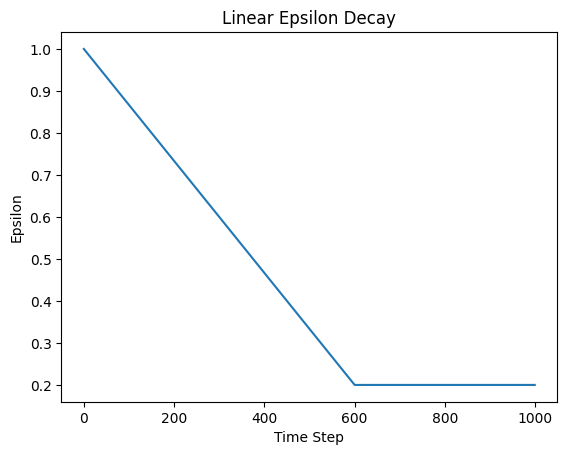

In [20]:
import matplotlib.pyplot as plt

eps_start = 1
eps_end = 0.2
schedule_duration = 1000

eps_values = [linear_epsilon_decay(eps_start, eps_end, t, 600) for t in range(schedule_duration)]

plt.plot(range(schedule_duration), eps_values)
plt.xlabel('Time Step')
plt.ylabel('Epsilon')
plt.title('Linear Epsilon Decay')
plt.show()

In [21]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        if self.__len__() < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)
            self.position = (self.position + 1) % self.max_size
        return 

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """

        rands = np.random.randint(0, self.__len__(), size = batch_size)
        
        obs_b = torch.stack([torch.from_numpy(self.data[i][0]) for i in rands])
        action_b = torch.stack([torch.tensor(self.data[i][1]) for i in rands ])
        reward_b = torch.stack([torch.tensor(self.data[i][2]) for i in rands])
        next_obs_b = torch.stack([torch.from_numpy(self.data[i][3]) for i in rands])
        terminated_b = torch.stack([torch.tensor(self.data[i][4]) for i in rands])
        return (obs_b, action_b, reward_b, next_obs_b, terminated_b)

In [22]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # Zero out the gradient
    q.zero_grad()
    optimizer.zero_grad()
    # Calculate the TD-Target
    with torch.no_grad():
        td_target = rew + torch.max(q_target(next_obs),1)[0] * gamma * (1-torch.Tensor(tm).float())

    # Calculate the loss. Hint: Pytorch has the ".gather()" function, which collects values along a specified axis using some specified indexes
    pred = q(obs).gather(1, act.to(torch.int64).unsqueeze(1)).squeeze(1)
    
    lossfun = nn.MSELoss()
    loss = lossfun(td_target, pred)
    
    # Backpropagate the loss and step the optimizer
    loss.backward()
    optimizer.step()
    

In [34]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):
        """
        Initialize the DQN agent.

        :param env: The environment.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: The initial epsilon value.
        :param eps_end: The final epsilon value.
        :param schedule_duration: The duration of the schedule (in timesteps).
        :param update_freq: How often to update the Q target.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq

        # TODO: Initialize the Replay Buffer
        self.buffer = ReplayBuffer(maxlen)

        # TODO: Initialize the Deep Q Network. Hint: Remember observation_space and action_space
        self.q = DQN_ram(env.observation_space.shape, env.action_space.n)

        # TODO: Initialize the second Q Network, the target network. Load the parameters of the first one into the second
        self.q_target = DQN_ram(env.observation_space.shape, env.action_space.n)
        params = copy.deepcopy(self.q.state_dict())
        self.q_target.load_state_dict(params)

        # TODO: Create an ADAM optimizer for the Q network
        self.optimizer = optim.Adam(self.q.parameters(), lr = lr)

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start
        actions = []
        
        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}  Transitions: {len(self.buffer)}')
                smoothing_window=20
                fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
                
                # Plot the episode length over time
                ax = axes[0]
                ax.plot(stats.episode_lengths[0:i_episode])
                ax.set_xlabel("Episode")
                ax.set_ylabel("Episode Length")
                ax.set_title("Episode Length over Time") 
                
                # Plot the episode reward over time
                ax = axes[1]
                rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
                ax.plot(rewards_smoothed[0:i_episode])
                ax.set_xlabel("Episode")
                ax.set_ylabel("Episode Reward (Smoothed)")
                ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
                plt.show()
            # Reset the environment and get initial observation
            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                # Get current epsilon value
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)
                # Choose action and execute
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon)
                actions.append(action)
                #print(self.q(torch.as_tensor(obs).unsqueeze(0).float()).argmax().detach().numpy())
                #print(action)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)
                #print(reward)
                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # Store sample in the replay buffer
                self.buffer.store(obs, action, reward, next_obs, terminated)

                # Sample a mini batch from the replay buffer
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)
                
                # Update the Q network
                update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch, 
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                # Update the current Q target
                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(copy.deepcopy(self.q.state_dict()))
                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    #print(episode_time)
                    break
                obs = next_obs
        return stats

Training on ALE/Pacman-ram-v5
Observation space: Box(0, 255, (128,), uint8)
Action space: Discrete(5)

Episode 100 of 1000  Time Step: 40367  Epsilon: 0.722  Transitions: 40367


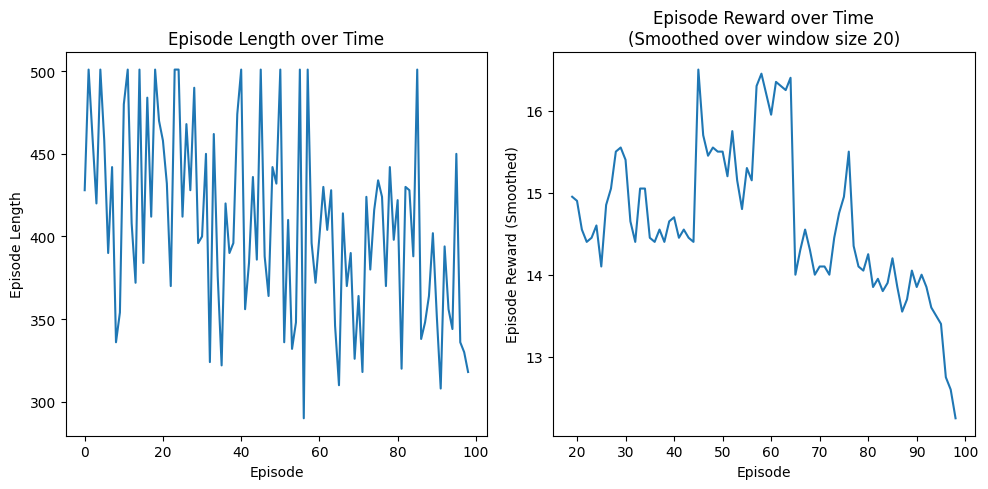

In [ ]:
env = gym.make('ALE/Pacman-ram-v5')

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit

LR = 0.002
BATCH_SIZE = 16
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 0.9
EPS_END = 0.02
SCHEDULE_DURATION = 200_000
NUM_EPISODES = 1000
DISCOUNT_FACTOR = 0.99

# Even though I played around with the hyperparameters I was not able to achieve a better result than
# the original set.

# Train DQN
agent = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats = agent.train(NUM_EPISODES)

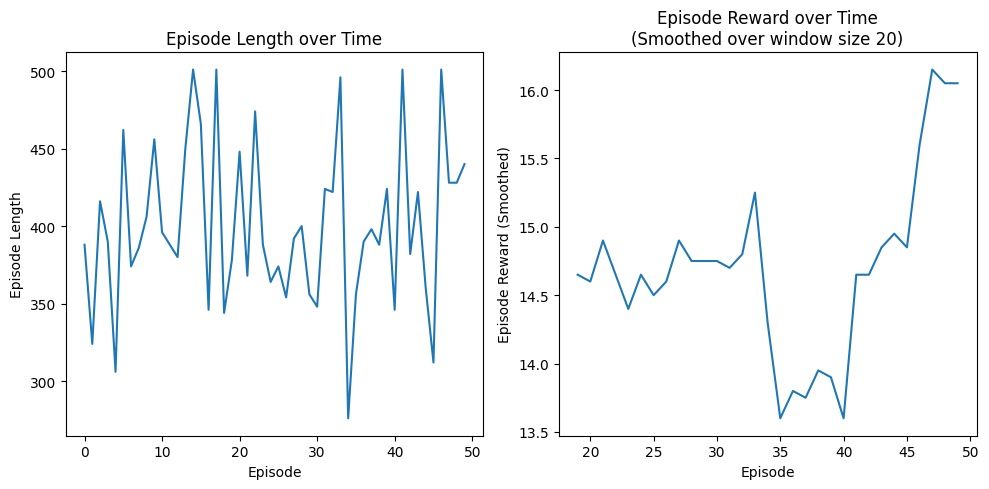

In [25]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time") 

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()


In [26]:
def playgame(policy, env, max_steps = 2_000):
    obs, _ = env.reset()
    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        #print(action)
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            print("Hi hello why") 
            env.reset()
            env.close()
            break
env = gym.make('ALE/Pacman-ram-v5', render_mode="human")
policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
playgame(policy, env)

Hi hello why


In [ ]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    env = gym.make('ALE/Pacman-ram-v5', render_mode="rgb_array")
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")